# Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the option).


## Setup


### Downloading helper functions


In [1]:
import requests
from pathlib import Path

# Creating directory
!mkdir helper_functions

# Downloading helper functions
if Path('helper_functions/helper_functions.py').is_file():
    print('helper_functions.py already exists, skipping download')
else:
    print('Downloading helper_functions.py')
    request = requests.get(
        'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py'
    )
    with open('helper_functions/helper_functions.py', 'wb') as f:
        f.write(request.content)

mkdir: helper_functions: File exists
helper_functions.py already exists, skipping download


### Importing libraries


In [2]:
from typing import Tuple, Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import SGD

from helper_functions.helper_functions import accuracy_fn
from helper_functions.helper_functions import plot_predictions, plot_decision_boundary

### Setting device


In [3]:
# Using gpu if available
device = 'mps' if torch.mps.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: mps


### Defining functions


In [4]:
# Function to automatically run training loop
def training_loop(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    epochs: int,
    train_data: Tuple[torch.Tensor, torch.Tensor],
    validation_data: Tuple[torch.Tensor, torch.Tensor] | None = None,
) -> Dict[str, List[float]]:
    X_train, y_train = train_data
    X_val, y_val = validation_data

    data_tracking = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    validation_print = ''

    for epoch in range(epochs):
        model.train()

        train_logits = model(X_train).squeeze()
        train_preds = torch.round(torch.sigmoid(train_logits))

        training_loss = loss_fn(train_logits, y_train)
        data_tracking['train_loss'].append(training_loss)

        training_acc = accuracy_fn(train_preds, y_train)
        data_tracking['train_acc'].append(training_acc)

        optimizer.zero_grad()
        training_loss.backward()

        optimizer.step()

        if validation_data != None:
            with torch.inference_mode():
                model.eval()
                val_logits = model(X_val).squeeze()
                val_preds = torch.round(torch.sigmoid(val_logits))

                validation_loss = loss_fn(val_logits, y_val)
                data_tracking['val_loss'].append(validation_loss)

                validation_acc = accuracy_fn(val_preds, y_val)
                data_tracking['val_acc'].append(validation_acc)

                validation_print = f'Validation loss: {validation_loss:.3f} | Validation acc: {validation_acc:.3f} |'

        if (epoch + 1) % 10:
            print(
                f'| Epoch: {epoch + 1}',
                f'\n| Training loss: {training_loss:.2f} | Training acc: {training_acc:.2f} |',
                validation_print,
            )
            print('-' * 90)

## 1- Making classification data

We're creating a "toy dataset", this is a dataset that is small enough to experiment, but sizeable enough to practice fundamentals.


In [5]:
# Making 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42,
)

In [6]:
# Checking length of features and labels
len(X), len(y)

(1000, 1000)

In [7]:
# Visualizing samples
print('First 5 samples of X:\n', X[:5])
print('\nFirst 5 samples of y:\n', y[:5])

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 samples of y:
 [1 1 1 1 0]


In [8]:
# Creating Pandas DataFrame from data
circles = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'label': y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


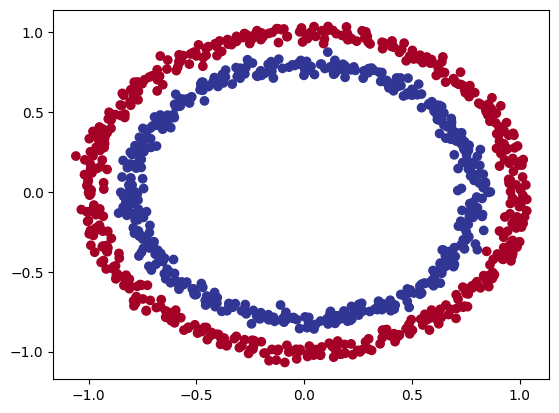

In [9]:
# Visualizing data
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

### 1.1- Setting data to tensors


In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

In [11]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2- Building a model

Building a model to classify the blue and red dots. To do this, we'll set-up device agnostic code, construct a model (by subclassing `nn.Module`), defining a loss function and optimizer, and creating a training and testing loop.


### 2.1- Creating model

Our model is composed of 2 linear layers. The first one takes tensors with 2 features, and outputs a tensor with 5 features. The second layer receives tensors with 5 features and outputs a single feature tensor.

The model's forward method outlines the forward pass in the neural network, it takes the input x (a tensor), passes it through the first and the second layers, then outputting a scalar tensor.


In [12]:
# Defining classifier
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Creating linear layers
        self.linear_layer_1 = nn.Linear(in_features=2, out_features=5)
        self.linear_layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_layer_1(x)

        return self.linear_layer_2(x)

### 2.2- Instantiating model and sending it to target device


In [13]:
# Instantiating model and sending it to gpu
model = CircleModel().to(device)

In [14]:
# Checking model and weights
model, model.state_dict()

(CircleModel(
   (linear_layer_1): Linear(in_features=2, out_features=5, bias=True)
   (linear_layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer_1.weight',
               tensor([[ 0.3360,  0.2349],
                       [-0.3790,  0.6941],
                       [ 0.5366, -0.6293],
                       [ 0.2579,  0.5049],
                       [-0.4792, -0.2779]], device='mps:0')),
              ('linear_layer_1.bias',
               tensor([ 0.1450, -0.1328, -0.2618,  0.6189,  0.1197], device='mps:0')),
              ('linear_layer_2.weight',
               tensor([[-0.3537,  0.0037, -0.1993, -0.4061, -0.3619]], device='mps:0')),
              ('linear_layer_2.bias', tensor([-0.1783], device='mps:0'))]))

### 2.3- Recreating model with `nn.Sequential`

`nn.Sequential` is a simple way of creating models. It's useful when you are simply passing the input `x` through the layers in a sequential manner. Although easier, it's often preferred to use the class method for creating models, for its increased ability to create more complex models, that involve more than a few forward passes.


In [15]:
# Using nn.Sequential
sequential_model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

In [16]:
# Visualizing model
sequential_model, sequential_model.state_dict()

(Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('0.weight',
               tensor([[ 0.5471,  0.6282],
                       [-0.3883, -0.2221],
                       [-0.0846, -0.4663],
                       [-0.5168,  0.3551],
                       [ 0.6076, -0.3419]], device='mps:0')),
              ('0.bias',
               tensor([ 0.4033,  0.5660,  0.5894, -0.6204,  0.6532], device='mps:0')),
              ('1.weight',
               tensor([[ 0.0233,  0.1382, -0.1516,  0.4419, -0.0582]], device='mps:0')),
              ('1.bias', tensor([-0.4066], device='mps:0'))]))

### 2.4- Making untrained predictions


In [17]:
# Making predictions
with torch.inference_mode():
    untrained_preds = sequential_model(X_test.to(device))

print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length of test samples: {len(X_test)}, Shape: {X_test.shape}')
print(f'\nFist 10 predictions:\n{torch.round(untrained_preds[:10])}')
print(f'\nFirst 10 labels:\n{y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

Fist 10 predictions:
tensor([[-1.],
        [-1.],
        [-1.],
        [ 0.],
        [-1.],
        [-1.],
        [-1.],
        [ 0.],
        [-1.],
        [-1.]], device='mps:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 1., 0., 0., 1.], device='mps:0')


## 3- Picking a Loss Function and Optimizer

Loss functions and optimizers are usually problem specific. For binary classification, we use _Binary Cross Entropy_, since it expects a binary label. For classification problems where you have more than two labels for instance, you may use _Categorical Cross Entropy_. For regression problems, you may want _MAE (Mean Absolute Error)_, of _MSE (Mean Squared Error)_, since you'll likely be dealing with distance to the actual, instead of trying to predict a specific number.

In our case, the loss function used is the `BCEWithLogitsLoss` ("_BCE_" stands for Binary Cross Entropy).This loss combines a _Sigmoid_ layer and the `BCELoss` in one class. This is done as a convenience, since we want the output restricted between 0 and 1, and `BCELoss` doesn't transform the data so that it is in that interval. As the name says, a `BCEWithLogitsLoss` function takes the logits (unprocessed predictions), whereas a `BCELoss` function takes the processed predictions (passed through a sigmoid function and rounded).

When it comes to optimizers, two of the most common ones are _SGD (Stochastic Gradient Descent)_ and _Adam (Adaptive Moment Estimation)_. There are so many more, and each one has its advantage and disadvantage.


In [18]:
# Setting up the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setting up the optimizer
optimizer = SGD(
    params=sequential_model.parameters(),
    lr=0.1,
)

## 4- Train model

Our model outputs are going to be raw **_logits_**. We can convert these **_logits_** into **_prediction probabilities_** by passing them to some kind of activation function (such as sigmoid for binary classification, or softmax for multi-class classification). Then we can convert the model's prediction probabilities to **_prediction labels_** by either rounding them or taking the `argmax()`.


In [19]:
# Training model
training_loop(
    model=model,
    optimizer=optimizer,
    epochs=100,
    loss_fn=loss_fn,
    train_data=(X_train, y_train),
    validation_data=(X_test, y_test),
)

| Epoch: 1 
| Training loss: 0.72 | Training acc: 50.62 | Validation loss: 0.731 | Validation acc: 47.500 |
------------------------------------------------------------------------------------------
| Epoch: 2 
| Training loss: 0.72 | Training acc: 50.62 | Validation loss: 0.731 | Validation acc: 47.500 |
------------------------------------------------------------------------------------------
| Epoch: 3 
| Training loss: 0.72 | Training acc: 50.62 | Validation loss: 0.731 | Validation acc: 47.500 |
------------------------------------------------------------------------------------------
| Epoch: 4 
| Training loss: 0.72 | Training acc: 50.62 | Validation loss: 0.731 | Validation acc: 47.500 |
------------------------------------------------------------------------------------------
| Epoch: 5 
| Training loss: 0.72 | Training acc: 50.62 | Validation loss: 0.731 | Validation acc: 47.500 |
------------------------------------------------------------------------------------------
| Epo

## 5- Making predictions and evaluate model

From the metrics, it seems the model isn't doing well in learning the patterns in the data. To inspect this further, we'll make the predictions visual.


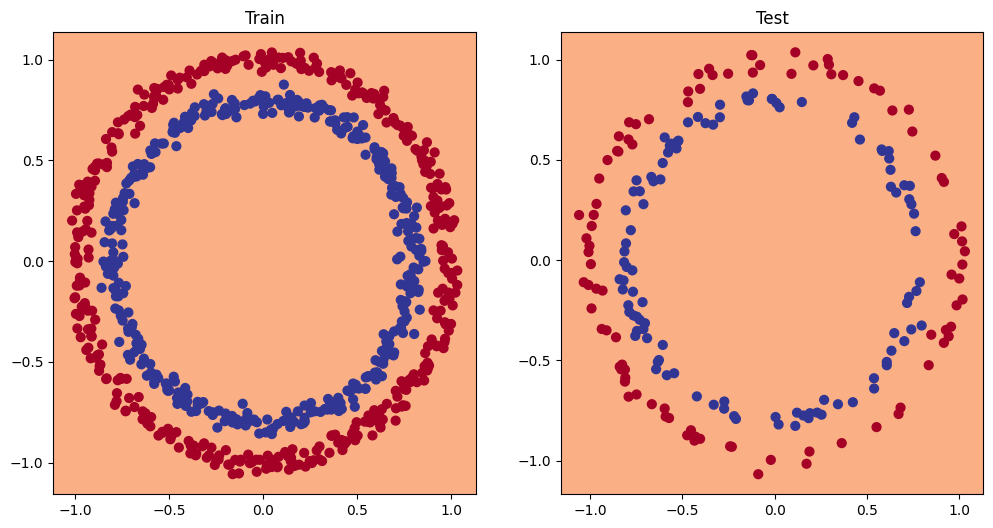

In [20]:
# Plot decision boundary of the model

# Train plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(sequential_model, X_train, y_train)

# Test plot
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(sequential_model, X_test, y_test)

## 6- Saving model


In [ ]:
# Creating models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Creating model save path
MODEL_NAME = 'classification.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/improved_classification.pth')

In [22]:
# Saving model state_dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [23]:
# Loading model
model = CircleModel().to(device)
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [24]:
X_test.to(device)

tensor([[ 0.6063, -0.5078],
        [-0.4293, -0.8803],
        [-0.7711, -0.0511],
        [-1.0086, -0.1240],
        [ 0.6576,  0.3369],
        [ 0.3421, -0.7187],
        [ 0.7162, -0.2138],
        [-0.8440,  0.6172],
        [-0.4043, -0.8912],
        [ 0.1546, -0.7750],
        [ 0.7671, -0.1540],
        [-0.8189, -0.1016],
        [ 0.6704, -0.7675],
        [-0.6657, -0.7185],
        [-1.0034,  0.0713],
        [-0.8014, -0.0344],
        [-0.8157, -0.0105],
        [-0.6425, -0.5441],
        [ 1.0168, -0.1964],
        [-0.7469, -0.2822],
        [-0.7646, -0.2763],
        [ 0.5373, -0.5891],
        [-0.7678, -0.1579],
        [ 0.7272, -0.1833],
        [-0.6569,  0.3930],
        [ 0.7313,  0.3701],
        [-0.2733, -0.7051],
        [-0.3305, -0.7212],
        [-0.4132,  0.9276],
        [-0.8054,  0.0834],
        [-0.6810,  0.7025],
        [ 0.9266, -0.3483],
        [-0.5961, -0.7401],
        [ 0.8473, -0.3720],
        [ 0.3701,  0.9224],
        [ 0.1830, -0

In [25]:
# Predicting and checking validity
model.eval()
with torch.inference_mode():
    loaded_lr_preds = model(X_test)

torch.equal(loaded_lr_preds, y_preds)

NameError: name 'y_preds' is not defined